In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# We'll predict if a person will like a movie based on their age and income
# Age (years), Income (thousands), Likes Action Movies (0=No, 1=Yes)
data = [
    [25, 30, 1],  # Young, low income → likes action
    [25, 35, 1],  # Young, low income → likes action
    [30, 40, 1],  # Young-ish, medium income → likes action
    [35, 50, 0],  # Middle age, medium income → doesn't like action
    [40, 60, 0],  # Middle age, high income → doesn't like action
    [45, 70, 0],  # Older, high income → doesn't like action
    [50, 80, 0],  # Older, high income → doesn't like action
    [22, 25, 1],  # Very young, low income → likes action
    [28, 45, 1],  # Young, medium income → likes action
    [42, 65, 0],  # Middle age, high income → doesn't like action
    [38, 55, 0],  # Middle age, medium-high income → doesn't like action
    [26, 32, 1],  # Young, low income → likes action
]

In [9]:
data=np.array(data)
X=data[:,:2]
y=data[:, 2]

In [10]:
class SimpleDecisionRule:
    """
    This is our simple 'weak learner'
    It makes one simple rule like: "If age < 35, then likes action movies"
    """
    
    def __init__(self):
        self.rule=None
        self.prediction_if_true=None
        self.prediction_if_false=None
    
    
    
    def fit(self,X,y):
        # We need to find the best rule
        best_accuracy=0
        for age_threshold in [30,35,40]:
            predictions = (X[:, 0] < age_threshold).astype(int)
            accuracy = np.mean(predictions == y)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                self.rule = f"age < {age_threshold}"
                self.prediction_if_true = 1
                self.prediction_if_false = 0
        
        # Try different income thresholds
        for income_threshold in [40, 50, 60]:
            # Rule: "If income < threshold, predict 1, else predict 0"
            predictions = (X[:, 1] < income_threshold).astype(int)
            accuracy = np.mean(predictions == y)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                self.rule = f"income < {income_threshold}"
                self.prediction_if_true = 1
                self.prediction_if_false = 0
            
            
    def predict(self,x):
        if "age" in self.rule:
            threshold = int(self.rule.split("< ")[1])
            condition = X[:, 0] < threshold
        else:  # income rule
            threshold = int(self.rule.split("< ")[1])
            condition = X[:, 1] < threshold
        
        return np.where(condition, self.prediction_if_true, self.prediction_if_false)

        

In [11]:
class SimpleBagging:
    """
    Simple Bagging implementation
    """
    def __init__(self, n_models=5):
        self.n_models = n_models
        self.models = []
        self.bootstrap_samples = []
    
    def create_bootstrap_sample(self, X, y):
        """
        Create a bootstrap sample (sampling with replacement)
        """
        n_samples = len(X)
        # Randomly pick indices (with replacement)
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices], indices
    
    def fit(self, X, y):
        """
        Train multiple models on different bootstrap samples
        """
        print(f"\nTraining {self.n_models} models with bagging...")
        print("-" * 50)
        
        for i in range(self.n_models):
            print(f"\nModel {i+1}:")
            
            # Create bootstrap sample
            X_bootstrap, y_bootstrap, indices = self.create_bootstrap_sample(X, y)
            
            print(f"  Bootstrap sample indices: {indices}")
            print(f"  Bootstrap sample:")
            print("  Age | Income | Likes")
            for j in range(len(X_bootstrap)):
                print(f"  {X_bootstrap[j,0]:2.0f}  | {X_bootstrap[j,1]:2.0f}     | {'Yes' if y_bootstrap[j] == 1 else 'No'}")
            
            # Train model on bootstrap sample
            model = SimpleDecisionRule()
            model.fit(X_bootstrap, y_bootstrap)
            
            print(f"  Learned rule: {model.rule}")
            
            # Store model and bootstrap info
            self.models.append(model)
            self.bootstrap_samples.append(indices)
    
    def predict(self, X):
        """
        Make predictions by combining all models (majority vote)
        """
        all_predictions = []
        
        print(f"\nMaking predictions for new data...")
        print("-" * 40)
        
        for i, model in enumerate(self.models):
            pred = model.predict(X)
            all_predictions.append(pred)
            print(f"Model {i+1} ({model.rule}): {pred}")
        
        # Convert to array for easier manipulation
        all_predictions = np.array(all_predictions)
        
        # Majority voting
        final_predictions = []
        for i in range(len(X)):
            votes = all_predictions[:, i]
            # Count votes for each class
            vote_counts = Counter(votes)
            # Get the class with most votes
            final_pred = vote_counts.most_common(1)[0][0]
            final_predictions.append(final_pred)
        
        print(f"\nFinal predictions (majority vote): {final_predictions}")
        return np.array(final_predictions)



SINGLE MODEL APPROACH
Single model learned rule: age < 35
Single model predictions: [1 1 1 0 0 0 0 1 1 0 0 1]
Actual labels:            [1 1 1 0 0 0 0 1 1 0 0 1]
Single model accuracy: 1.00

BAGGING APPROACH

Training 5 models with bagging...
--------------------------------------------------

Model 1:
  Bootstrap sample indices: [ 6  3 10  7  4  6  9  2  6 10 10  7]
  Bootstrap sample:
  Age | Income | Likes
  50  | 80     | No
  35  | 50     | No
  38  | 55     | No
  22  | 25     | Yes
  40  | 60     | No
  50  | 80     | No
  42  | 65     | No
  30  | 40     | Yes
  50  | 80     | No
  38  | 55     | No
  38  | 55     | No
  22  | 25     | Yes
  Learned rule: age < 35

Model 2:
  Bootstrap sample indices: [ 4  3  7  7  2  5  4  1  7 11  5  1]
  Bootstrap sample:
  Age | Income | Likes
  40  | 60     | No
  35  | 50     | No
  22  | 25     | Yes
  22  | 25     | Yes
  30  | 40     | Yes
  45  | 70     | No
  40  | 60     | No
  25  | 35     | Yes
  22  | 25     | Yes
  26  | 32    

IndexError: index 12 is out of bounds for axis 1 with size 12

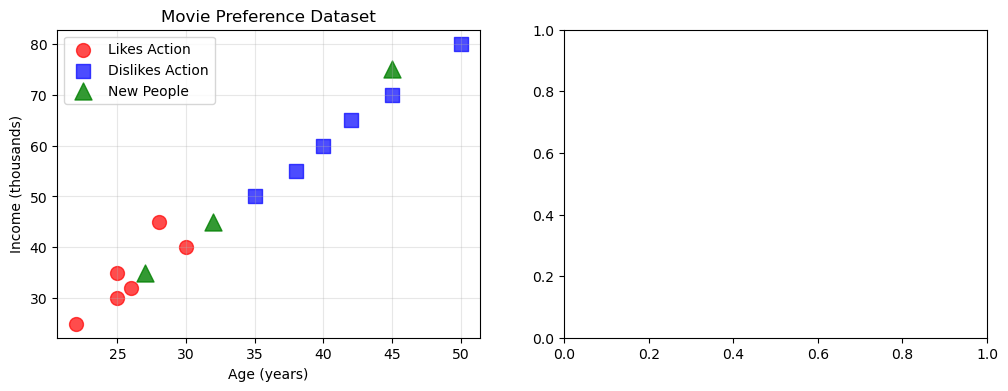

In [12]:
np.random.seed(42)

# Train a single model first (for comparison)
print("\n" + "="*60)
print("SINGLE MODEL APPROACH")
print("="*60)

single_model = SimpleDecisionRule()
single_model.fit(X, y)
single_predictions = single_model.predict(X)

print(f"Single model learned rule: {single_model.rule}")
print(f"Single model predictions: {single_predictions}")
print(f"Actual labels:            {y}")
print(f"Single model accuracy: {np.mean(single_predictions == y):.2f}")

# Now let's try bagging
print("\n" + "="*60)
print("BAGGING APPROACH")
print("="*60)

bagging = SimpleBagging(n_models=5)
bagging.fit(X, y)

bagging_predictions = bagging.predict(X)
print(f"Actual labels:     {y}")
print(f"Bagging accuracy: {np.mean(bagging_predictions == y):.2f}")

# Test on new data
print("\n" + "="*60)
print("TESTING ON NEW PEOPLE")
print("="*60)

# New people to make predictions for
new_people = np.array([
    [27, 35],  # Young person, medium income
    [45, 75],  # Older person, high income
    [32, 45],  # Middle age, medium income
])

print("New people to predict for:")
print("Age | Income")
print("-" * 12)
for person in new_people:
    print(f"{person[0]:2.0f}  | {person[1]:2.0f}")

# Single model predictions
single_new_pred = single_model.predict(new_people)
print(f"\nSingle model predictions: {single_new_pred}")

# Bagging predictions
bagging_new_pred = bagging.predict(new_people)
print(f"Bagging predictions: {bagging_new_pred}")

# Visualize the data
plt.figure(figsize=(12, 4))

# Plot 1: Original data
plt.subplot(1, 2, 1)
likes_action = X[y == 1]
dislikes_action = X[y == 0]

plt.scatter(likes_action[:, 0], likes_action[:, 1], c='red', marker='o', s=100, alpha=0.7, label='Likes Action')
plt.scatter(dislikes_action[:, 0], dislikes_action[:, 1], c='blue', marker='s', s=100, alpha=0.7, label='Dislikes Action')

# Add new people
plt.scatter(new_people[:, 0], new_people[:, 1], c='green', marker='^', s=150, alpha=0.8, label='New People')

plt.xlabel('Age (years)')
plt.ylabel('Income (thousands)')
plt.title('Movie Preference Dataset')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Decision boundaries (simplified visualization)
plt.subplot(1, 2, 2)
age_range = np.arange(20, 55, 1)
income_range = np.arange(20, 90, 1)
Age, Income = np.meshgrid(age_range, income_range)
grid_points = np.column_stack([Age.ravel(), Income.ravel()])

# Get bagging predictions for grid
bagging_grid_pred = bagging.predict(grid_points)
bagging_grid_pred = bagging_grid_pred.reshape(Age.shape)

plt.contourf(Age, Income, bagging_grid_pred, levels=1, alpha=0.3, colors=['blue', 'red'])
plt.scatter(likes_action[:, 0], likes_action[:, 1], c='red', marker='o', s=100, alpha=0.7, label='Likes Action')
plt.scatter(dislikes_action[:, 0], dislikes_action[:, 1], c='blue', marker='s', s=100, alpha=0.7, label='Dislikes Action')
plt.scatter(new_people[:, 0], new_people[:, 1], c='green', marker='^', s=150, alpha=0.8, label='New People')

plt.xlabel('Age (years)')
plt.ylabel('Income (thousands)')
plt.title('Bagging Decision Boundary')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY CONCEPTS EXPLAINED:")
print("="*60)
print("1. BOOTSTRAP SAMPLING:")
print("   - Each model sees a different random sample of the data")
print("   - Some data points appear multiple times, others might not appear at all")
print("   - This creates diversity among models")
print()
print("2. MAJORITY VOTING:")
print("   - Each model makes its own prediction")
print("   - Final prediction = what most models agree on")
print("   - Reduces impact of any single model's mistakes")
print()
print("3. WHY BAGGING WORKS:")
print("   - Individual models might overfit to specific data points")
print("   - By averaging many models, we get more stable predictions")
print("   - Like asking multiple experts instead of just one!")

In [ ]:
"""
1. REDUCES OVERFITTING:
   - Normal tree might always pick the same "strong" features
   - Random selection forces trees to explore different patterns
   
2. INCREASES DIVERSITY:
   - Each tree becomes different from others
   - Different trees capture different aspects of the data
   
3. HANDLES FEATURE CORRELATION:
   - If features are correlated, normal trees might always pick the same ones
   - Random selection gives chance to other useful features
   
4. IMPROVES GENERALIZATION:
   - Ensemble becomes more robust to new, unseen data
"""

In [14]:
"""
KEY POINTS:

1. WHAT HAPPENS:
   - At each split in each tree, Random Forest randomly selects a subset of features
   - Only these selected features are considered for that specific split
   - Different splits may use different feature subsets

2. HOW MANY FEATURES:
   - Classification default: sqrt({len(feature_names)}) = {int(np.sqrt(len(feature_names)))} features
   - Regression default: {len(feature_names)}/3 = {len(feature_names)//3} features
   - You can also specify exact numbers: max_features=2

3. WHY IT WORKS:
   - Prevents any single feature from dominating all trees
   - Creates diverse trees that capture different patterns
   - Reduces correlation between trees in the ensemble
   - Better generalization to new data

4. TUNING ADVICE:
   - Start with default ('sqrt' for classification)
   - Try smaller values if you have many features
   - Try larger values if you have few features
   - Use cross-validation to find optimal value
"""

"\nKEY POINTS:\n\n1. WHAT HAPPENS:\n   - At each split in each tree, Random Forest randomly selects a subset of features\n   - Only these selected features are considered for that specific split\n   - Different splits may use different feature subsets\n\n2. HOW MANY FEATURES:\n   - Classification default: sqrt({len(feature_names)}) = {int(np.sqrt(len(feature_names)))} features\n   - Regression default: {len(feature_names)}/3 = {len(feature_names)//3} features\n   - You can also specify exact numbers: max_features=2\n\n3. WHY IT WORKS:\n   - Prevents any single feature from dominating all trees\n   - Creates diverse trees that capture different patterns\n   - Reduces correlation between trees in the ensemble\n   - Better generalization to new data\n\n4. TUNING ADVICE:\n   - Start with default ('sqrt' for classification)\n   - Try smaller values if you have many features\n   - Try larger values if you have few features\n   - Use cross-validation to find optimal value\n"

In [15]:
"""
MAIN HYPERPARAMETERS:

1. n_estimators (Number of Trees)
   - How many decision trees to build
   - More trees = better performance but slower training
   - Typical range: 50-500
   - Default: 100

2. max_depth (Tree Depth)
   - Maximum depth each tree can grow
   - Deeper trees can capture more complex patterns but may overfit
   - Default: None (trees grow until pure or min_samples_split)
   - Typical range: 3-20

3. min_samples_split
   - Minimum samples required to split a node
   - Higher values prevent overfitting
   - Default: 2
   - Typical range: 2-20

4. min_samples_leaf
   - Minimum samples required in a leaf node
   - Higher values make model more conservative
   - Default: 1
   - Typical range: 1-10

5. max_features
   - Number of features to consider at each split
   - Key difference from regular bagging!
   - Options: 'sqrt', 'log2', int, float, None
   - Default: 'sqrt' for classification

6. bootstrap
   - Whether to use bootstrap sampling
   - Default: True
   - Set to False for "pasting" instead of bagging

7. oob_score (Out-of-Bag Score)
   - Use out-of-bag samples for validation
   - Default: False
   - Useful when you don't have separate validation set

8. n_jobs
   - Number of CPU cores to use
   - -1 = use all available cores
   - Default: None (single core)

9. random_state
   - For reproducible results
   - Default: None
"""

'\nMAIN HYPERPARAMETERS:\n\n1. n_estimators (Number of Trees)\n   - How many decision trees to build\n   - More trees = better performance but slower training\n   - Typical range: 50-500\n   - Default: 100\n\n2. max_depth (Tree Depth)\n   - Maximum depth each tree can grow\n   - Deeper trees can capture more complex patterns but may overfit\n   - Default: None (trees grow until pure or min_samples_split)\n   - Typical range: 3-20\n\n3. min_samples_split\n   - Minimum samples required to split a node\n   - Higher values prevent overfitting\n   - Default: 2\n   - Typical range: 2-20\n\n4. min_samples_leaf\n   - Minimum samples required in a leaf node\n   - Higher values make model more conservative\n   - Default: 1\n   - Typical range: 1-10\n\n5. max_features\n   - Number of features to consider at each split\n   - Key difference from regular bagging!\n   - Options: \'sqrt\', \'log2\', int, float, None\n   - Default: \'sqrt\' for classification\n\n6. bootstrap\n   - Whether to use bootst